
---

## 🔹 Why Positional Encoding is Needed

### 🔁 In RNNs:
- Sequence order is *inherent* because tokens are processed one by one.
- The state at each time step carries information about the sequence up to that point.

### ⚡ In Transformers:
- All tokens are processed **in parallel** using **self-attention**, which is **permutation-invariant**.
- That means:
  > “I love you.”  
  and  
  > “You love I.”  
  would have **the same attention outputs** without some form of position information.

So… **we need a way to tell the model the order of tokens**, since the architecture itself doesn't care about token position.

---

## 🔹 What is Positional Encoding?

**Positional Encoding** is a way to inject information about the position of each token in the sequence into its embedding, so that the transformer can take sequence order into account.

We modify the input token embeddings as:
```
Input to Transformer = TokenEmbedding + PositionalEncoding
```

So now each input vector is aware of both:
- What the token **is** (from the embedding), and  
- **Where** it is in the sequence (from the positional encoding)


# Approaches that leads to Sinusoidal Encoding


---

### 1. Discrete Positional Encoding

- **Basic Idea**:  
  Use the index of each token as its position (e.g., `[0, 1, 2, ..., n]`).  
  This is called **absolute positional encoding**, where each position is relative to a fixed global origin (start of the sequence).

- **Issue with Raw Indices**:  
  - For long sequences, positional values can get large (e.g., 499 for a 500-token sequence).  
  - Neural networks prefer inputs centered around 0 and with balanced positive/negative values.  
  - Large unscaled inputs can cause **EXPLODING GRADIENTS** and **UNSTABLE TRAINING**.

- **Idea of Normalization**:  
  - Normalize positions by dividing each index by the sequence length (brings values to [0, 1] range).  
  - Helps keep values small and training stable.

- **Problem with Normalization**:  
  - Normalized values become **ambiguous** across sequences of different lengths.  
  - Example: `0.8` in a sequence of length 50 means position 40; in length 100, it means position 80.  
  - The model can't tell **where `0.8` truly lies** without knowing the sequence length.  
  - This inconsistency leads to **confusion** and poor generalization on variable-length inputs.

---



---

### 2. Binary Positional Encoding

- **Concept**:  
  Instead of using discrete index values directly, we can represent each position as a **binary vector** of its index.

- **Example**:  
  For a 4-dimensional binary encoding, we can represent up to `2⁴ = 16` positions.  
  - Position 0 → `[0, 0, 0, 0]`  
  - Position 1 → `[1, 0, 0, 0]`  
  - Position 2 → `[0, 1, 0, 0]`  
  - Position 3 → `[1, 1, 0, 0]`  
  - …and so on.

- **Integration**:  
  This binary vector is **added to the token embedding** at each position, embedding positional information directly into the input.

- **Advantages**:
  - Keeps the values small and within a fixed range.
  - Naturally discrete and sparse, which can help stability.
  - Simple to implement for fixed-length sequences.

---

### ❌ Limitations of Binary Positional Encoding

Even though using a binary vector (e.g., 8-bit) to represent positions is technically feasible, this method has several serious drawbacks:

---

#### 1. **Discontinuous Nature**

- **Explanation**:  
  Binary encoding changes abruptly between consecutive positions. For example:
  - Position 3 → `0011`  
  - Position 4 → `0100`  
  These vectors are **very different**, even though the positions are only one step apart.
  
- **Why It's Bad**:  
  - Neural networks prefer smooth, continuous signals so they can learn general patterns.  
  - Abrupt changes in binary vectors disrupt this smoothness, making learning **harder** and **less efficient**.

---

#### 2. **Poor Relative-Distance Geometry**

- **Explanation**:  
  Binary encodings do not preserve **relative distance** between positions.  
  - Example: Position 2 → `0010`, Position 3 → `0011`  
  - The Hamming distance is **1**, but Position 1 → `0001` also has Hamming distance 1 from Position 0 → `0000`. There's no consistent geometric relationship.
  
- **Why It’s Bad**:  
  - Transformers and other models benefit from understanding *how far apart* tokens are.  
  - Binary vectors **don’t encode “closeness” or “distance”** in any meaningful way for the model.

---

#### 3. **Limited Range**

- **Explanation**:  
  A binary vector of `n` bits can only represent `2ⁿ` unique positions.  
  - 8 bits → max 256 positions  
  - 10 bits → 1024 positions

- **Why It’s Bad**:  
  - Long sequences (e.g., 512, 1024, 2048 tokens) are common in modern transformers.  
  - Using binary requires increasing the dimensionality, which increases model size and complexity.

---

#### 4. **Lack of Empirical Support**

- **Explanation**:  
  Despite being simple to implement, binary encoding **has not shown success in practice** on large-scale language or vision tasks.

- **Why It’s Bad**:  
  - Research and benchmarks overwhelmingly favor **smooth encodings** like:
    - **Sinusoidal (Vaswani et al., 2017)**  
    - **Rotary Positional Embeddings (RoPE)**  
    - **ALiBi (Attention with Linear Biases)**  
  - These methods are **continuous**, encode **relative** and **absolute** positions, and perform better in real-world scenarios.

---

### ✅ Why Smooth Encodings Work Better

- They allow **linear extrapolation** of positions.
- They preserve **relative order and distance** more naturally.
- They integrate better with **attention mechanisms**, enabling the model to generalize beyond the training sequence length.

---



---

### 🔧 Why Sunusoidal is better then Binary ?

- **Embedding size**: We use \( d = 4 \) to keep things small and human-readable.
- **Goal**: Focus solely on **positional encoding** \(p\), ignoring actual word embeddings \(e\).
- **What the model sees**:  
  \[
  x = e + p
  \]  
  In this case, we analyze how different positional encodings affect what the model sees via \(p\).

---

### 1 ▸ Define Two Kinds of Positional Vectors

| position | Sinusoid PE (toy) | Binary PE (4‑bit) |
|----------|-------------------|-------------------|
| 7        | [0.99, 0.14, 0.77, 0.64] | [0, 1, 1, 1] |
| 8        | [0.99, 0.17, 0.70, 0.71] | [1, 0, 0, 0] |

- **Sinusoid PE**:
  - Values change **smoothly and gradually** between positions.
  - Designed such that even large jumps (e.g., position 500 to 510) result in **small vector differences**.
  
- **Binary PE**:
  - Each number is represented in **standard binary**, e.g., 7 = `0111`, 8 = `1000`.
  - The vector **jumps drastically** between consecutive positions.

🔍 *Insight*: Sinusoidal changes allow the model to **interpolate** between positions. Binary flips create **discontinuous jumps**.

---

### 2 ▸ Pass Through a 1‑Layer "Model"

We simulate the effect of the two positional encodings by feeding them into a simple linear model:

```math
y = wᵀx,  loss = ½(y - t)²
```

Let’s define:

```math
w = [0.3, 0.7, 1.0, 0.5],  t = 1.00
```

---

#### ➤ Forward Pass Output

|                | Sinusoid 7 | Sinusoid 8 | Δy     | Binary 7 | Binary 8 | Δy      |
|----------------|------------|------------|--------|----------|----------|---------|
| Output (𝑦)     | **1.42**   | **1.46**   | +0.04  | **1.55** | **1.05** | **–0.50** |

- **Sinusoid**: Output shifts **smoothly** by +0.04.
- **Binary**: Output jumps **abruptly** by –0.50 due to flipped bits.

🔍 **Insight**:  
A small step in position causes a **predictable shift** in the sinusoidal case, but a **chaotic jump** in the binary case—even though the input meaning changed only slightly.

---

#### ➤ Gradient with Respect to Weights (𝑤)

We calculate the gradient of the loss as:

```math
∂loss/∂w = (y - t) × x
```

##### ✅ Sinusoidal Encoding

```math
y = 1.42 → y - t = 0.42
```

```python
grad = 0.42 * [0.99, 0.14, 0.77, 0.64]
     ≈ [0.42, 0.06, 0.32, 0.27]
```

→ Gradients are **well-distributed**, with **moderate energy** across all dimensions.

---

##### ❌ Binary Encoding

```math
y = 1.55 → y - t = 0.55
```

```python
grad = 0.55 * [0, 1, 1, 1]
     = [0.00, 0.55, 0.55, 0.55]
```

→ Gradient energy is **concentrated** only in the changed bits, and **zero** elsewhere.

---

### ⚠️ What Goes Wrong with Binary Encoding

- 🔄 **Seesawing Updates**: If we train on position 7, gradients pull weights one way.  
  Train next on position 8 → weights swing the opposite direction.
- 💥 **Instability**: These swings make convergence harder, unless you:
  - Use **very small learning rates**
  - Apply **gradient clipping**
- ❌ **Noisy Optimization Path**: The model **overreacts to bit flips** instead of learning smooth positional transitions.

---

### 3 ▸ Visualizing the Similarity Surface

The dot product \( S_{i,j} = p_i \cdot p_j \) gives a sense of how **similar** different positions are to each other.

| Sinusoid (smooth bands) | Binary (checkerboard) |
|-------------------------|-----------------------|
| ▒▒▓▓██▓▓▒▒··            | █□█□████□█··          |
| ▓▓██████▓▓··            | □█□██□□□█□··          |
| ██████████··            | ██████□□□█··          |

- **Sinusoid**:  
  - Produces **gradual decay** in similarity as distance increases.
  - Attention heads can easily **infer relative proximity** (e.g., token 7 is close to token 8).
  
- **Binary**:
  - Similarity is **binary and unpredictable**.
  - Close positions may appear unrelated; far ones may seem similar.
  - The model has no smooth structure to reason about **relative location**.

🔍 *Insight*: Sinusoid encodings allow for **locality awareness**. Binary encoding **destroys that structure**, forcing the model to memorize instead of interpolate.

---

### 4 ▸ Why Scaling Binary Doesn't Fix It

One might try to fix binary encoding by **scaling**:

#### Case 1: Too Small (e.g., scale = 0.01)
- The signal becomes **negligible** compared to word embeddings.
- Positional info is ignored → model degenerates into **bag-of-words** behavior.

#### Case 2: Big Enough to Matter (e.g., scale = 1)
- Positional jumps cause **gradient explosions**, **sawtooth loss**, and **poor convergence**.

🔍 *Insight*: Binary encoding creates a **trade-off** that cannot be resolved by scaling. Sinusoidal encoding avoids this issue altogether.

---

### 🧠 Key Takeaway

> **Backpropagation loves smooth, continuous, predictable gradients.**

Sinusoidal encodings provide:
- Smooth transitions
- Consistent gradient directions
- Relative distance awareness

Binary encodings:
- Create cliffs and flat regions in the loss surface
- Lead to unstable training
- Don’t generalize well

This is why sinusoidal, rotary, and ALiBi encodings dominate in both **theory and practice**.

---



---

You’ll notice that with **continuous encodings**, the curve is **smooth and predictable**—you can easily estimate intermediate positions by just "walking" a little further along the curve. But with **binary vectors**, it’s a different story altogether. That representation is a chaotic jumble of disconnected points, with no clear way to interpolate between positions.

This leads us to our next important insight:  
🔍 *We need a way to make the binary vector behave like a **discretized version of something continuous.***

In other words, we’re trying to find a function that **connects the dots** between positions in a **natural and smooth** manner. If you’ve studied geometry, what we’re really looking for is an **embedding manifold**.

And yes—if you’re using positional encodings, you now have permission to sound fancy and tell people *“we’re embedding our tokens along a learned manifold.”*

In plain terms, this means we're trying to construct a **curve** in the high-dimensional model space (`d_model`) such that, as you **move along that curve**, the model perceives you as advancing through the sequence in a **continuous and meaningful** way.

Designing positional encodings this way—where **position increases smoothly along a geometric path**—leads us to our next and more principled approach.

---



---

### 🌊 From Binary to Sine: Discretizing a Continuous Function

- In **binary positional encoding**, each position is represented as a vector of 0s and 1s (e.g., position 2 → `[0, 1, 0, 0]`).
- Each dimension can only **toggle** between 0 or 1 — it's **discrete**, **abrupt**, and lacks smooth transitions.

---

### ❗ The Problem

- We concluded that this **discrete nature** makes binary encoding unsuitable for deep learning.
- Why? Because models trained via backpropagation prefer **smooth**, **continuous**, and **interpolatable** signals — not sudden jumps between 0 and 1.

---

### ✅ The Insight

- What if we could **simulate** the 0→1→0 pattern of binary, but do it **smoothly**?
- That’s where the **sine function** comes in!

---

### 🌀 The Solution: Sinusoidal Encoding

- Each dimension in the positional encoding vector becomes a **sine wave**.
- These sine waves oscillate smoothly from 0 → 1 → 0 → -1 → 0, and so on.
- By **choosing the right frequency** for each dimension, we can:
  - Simulate **binary-like toggling**, but in a **continuous** form.
  - Preserve **positional patterns** while maintaining gradient flow.

---

### 📉 Exponentially Decaying Frequencies

- The sine waves across dimensions have **frequencies that decay exponentially**:
  $$
  \omega_j = \frac{2\pi}{2^j}
  $$
- The **first dimension** oscillates very fast (captures local position info).
- The **later dimensions** oscillate more slowly (capture broader trends across the sequence).

---

### 🎯 Result

- This gives us a **continuous, smooth, multi-scale positional encoding**.
- Each position in the sequence maps to a unique vector composed of **sine waves of varying frequency**.
- Unlike binary, it:
  - Supports **interpolation**
  - Maintains **relative distance awareness**
  - Is fully compatible with **gradient-based learning**

---



---

### 🚫 Limitation of Using Sinusoidal Functions for Positional Encoding

- When we use sine functions to encode positions, we're essentially embedding positions along a **smooth, periodic curve**.
- This periodicity is **inherent** in sine and cosine functions — after a certain number of steps, the values start to **repeat**.
  
For example:
- $$sin(0) = 0$$
- $$sin(2 \pi) = 0$$
- $$sin(4\pi) = 0$$



So, in a sinusoidal positional encoding:
> By construction, **position `n+1` will have a similar (sometimes identical) encoding to position `1`**, because the sine wave **repeats**.

---

### ⚠️ Why This Is a Problem

- This **aliasing** (repetition) is a side-effect of the **periodic nature** of trigonometric functions.
- In real-world sequences (like text), **position 1 and position n+1 should be *far apart***, not **near** or **similar**.
- But due to the sine wave looping back, the model may confuse distant positions if frequencies are not chosen carefully.

---

### 🔄 Connection to Finite Fourier Transforms

This issue is directly related to how **Discrete Fourier Transforms (DFT)** and **Finite Fourier Series** work:

#### 🧠 Key Facts About Finite Fourier Transforms:

1. In a finite sequence of length \(N\), the Fourier basis functions (sine and cosine) are **periodic** with period \(N\).
2. You only get **N unique frequencies** — beyond that, the frequencies start **repeating**.
3. Even among those, only **half the frequencies are linearly independent** due to symmetry (complex conjugates or sin/cos symmetry).
   - That’s what the statement **“only half the frequencies are unique”** refers to.
   - If you're using \(d\) embedding dimensions, only \(d/2\) frequencies produce **unique variations**.

---

### 🌀 Visualizing the Problem

If you plot the sine-based positional encodings:
- After a while, **position encodings start to look very similar**, especially when low frequencies dominate.
- The model might **struggle to distinguish position 10 from 42**, if both fall on **similar points in the wave cycle**.

---

### 🧩 Summary

| Problem                            | Explanation                                                                 |
|-----------------------------------|-----------------------------------------------------------------------------|
| Sinusoid wraps around             | Because it’s periodic → position `n+1` can "look like" position `1`        |
| Not suitable for long sequences   | Far-apart positions may receive similar encodings                          |
| Finite Fourier transform issue    | In any fixed-length sequence, you only get a limited set of unique frequency components |
| Half frequencies repeat           | Due to the symmetry in sine/cosine basis, many higher frequencies are just flipped or repeated forms of lower ones |

---

### 🛠️ How This Is Handled

- Modern positional encodings (like **RoPE**, **ALiBi**, or **learned encodings**) attempt to **solve this limitation** by:
  - Removing strict periodicity
  - Encoding **relative distance** directly
  - Allowing **unbounded positional representation** (e.g., ALiBi works for arbitrarily long sequences)

---


---

## ⚙️ What Is the Finite (Discrete) Fourier Transform?

The **Fourier Transform** decomposes a signal into a sum of sinusoids (sine and cosine waves). For **finite-length discrete signals**, we use the **Discrete Fourier Transform (DFT)**.

Given a signal of length `N`, the DFT represents it as a sum of `N` complex exponentials (or equivalently, sine and cosine waves of different frequencies):

```math
X_k = \sum_{n=0}^{N-1} x_n \cdot e^{-2\pi i \cdot kn/N}, \quad k = 0, 1, ..., N-1
```

Where:
- \( x_n \) is the input sequence,
- \( X_k \) is the \( k \)-th frequency component,
- \( e^{-2\pi i kn/N} \) is the rotating basis wave at frequency \( k \).

---

## 🔁 Periodicity of the Basis Functions

- All basis functions  $$e^{-2\pi i kn/N}$$  are **periodic**.
- For every integer \( k \), the wave completes \( k \) full cycles across the \( N \) data points.
- This means the representation **wraps around** after a certain point.

**Examples:**
- \( k = 0 \): constant signal (DC)
- \( k = 1 \): one full sine/cosine cycle over the sequence
- \( k = N/2 \): highest frequency before aliasing (Nyquist frequency)

---

## ❗ Symmetry and Redundancy

The DFT outputs are **complex**, but real-valued signals (like embeddings) lead to **conjugate symmetry** in the frequency spectrum:

```math
X_{N-k} = \overline{X_k}
```

- So for real input signals, **half of the DFT frequencies are redundant**.
- That's what people mean when they say:
  > "**Only half the frequencies are unique** in the finite Fourier transform."

---

## 🎯 Why This Matters in Positional Encoding

In sinusoidal positional encoding (used in transformers), the encoding for position `i` and dimension `j` is defined as:

```math
PE_{i,j} = \sin\left(\frac{i}{10000^{2j/d}}\right), \quad \cos\left(\frac{i}{10000^{2j/d}}\right)
```

This is essentially projecting the position `i` onto a set of **sinusoidal basis functions**, just like the DFT does for signals.

### ⚠️ The Problem

- Sine and cosine functions are **periodic**.
- So after some position, **the positional encodings start repeating**.
- For instance, using:

```math
\sin\left(\frac{2\pi i}{2^j}\right)
```

The values **cycle** every \( 2^j \) steps.

This leads to **aliasing**: positions that are **far apart** (like `i = 1` and `i = n + 1`) may get **similar or identical encodings**.

---

## 🧠 Visual Example (N = 8)

For a sequence of 8 positions (0 to 7), the DFT uses 8 frequency components. But:

- Frequencies \( k = 1 \) and \( k = 7 \) are mirror images,
- \( k = 2 \) and \( k = 6 \), \( k = 3 \) and \( k = 5 \), etc., are symmetric,
- So only **4 frequencies are truly unique**.

---

## 🔄 Consequences in Transformers

- Due to periodic repetition, the model can **confuse distant positions** (e.g., `1` and `513`) if their encodings overlap.
- This is especially problematic in **long sequences**, where encoding periodicity can lead to ambiguity.

---

## ✅ How Modern Solutions Fix This

| Encoding Method | Solution |
|-----------------|----------|
| **RoPE**        | Rotates queries/keys using complex multiplication with position-dependent frequencies. This captures **relative position** and avoids periodic aliasing. |
| **ALiBi**       | Adds a **linear bias** to attention scores depending on relative distance. Works for **arbitrary sequence lengths**. |
| **Learned PE**  | Uses trainable position vectors, avoiding any periodic structure entirely. |

---

## 📌 Summary Table

| Concept                         | Description |
|---------------------------------|-------------|
| Finite Fourier Transform (DFT)  | Decomposes signals into sine/cosine basis functions. |
| Only Half Frequencies Are Unique | Due to symmetry: \( X_{N-k} = \overline{X_k} \) for real inputs. |
| Sinusoidal Encoding Limitation  | Periodicity causes encodings to repeat, leading to ambiguity. |
| Problem in Transformers         | Distant positions may get similar encodings → confuses attention. |
| Solution                        | Use **non-periodic** (learned) or **relative** encodings (RoPE, ALiBi). |

---


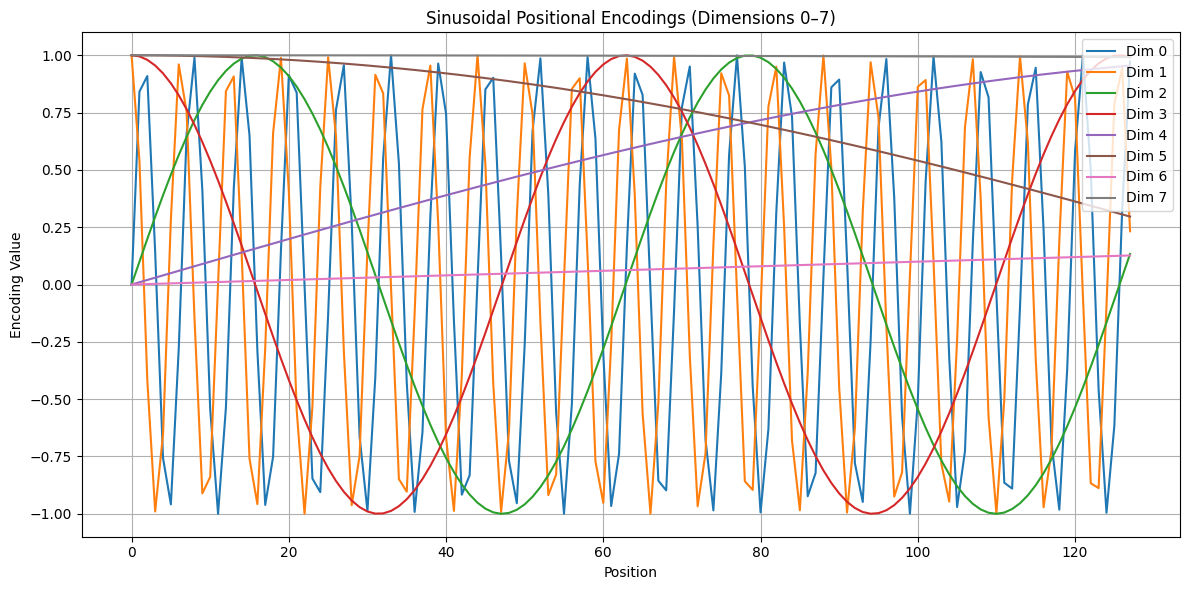

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sinusoidal_encoding(seq_len, d_model):
    """
    Generate a sinusoidal positional encoding matrix.
    
    Args:
        seq_len (int): Number of positions (sequence length).
        d_model (int): Embedding dimension.
    
    Returns:
        numpy.ndarray: Positional encoding matrix of shape (seq_len, d_model)
    """
    positions = np.arange(seq_len)[:, np.newaxis]        # Shape: (seq_len, 1)
    dims = np.arange(d_model)[np.newaxis, :]             # Shape: (1, d_model)

    # Compute angle rates for each dimension
    angle_rates = 1 / np.power(10000, (2 * (dims // 2)) / np.float32(d_model))
    angle_rads = positions * angle_rates                 # Shape: (seq_len, d_model)

    # Initialize positional encoding matrix
    pos_encoding = np.zeros_like(angle_rads)
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])  # Apply sin to even indices
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])  # Apply cos to odd indices

    return pos_encoding

# Settings
seq_len = 128   # Number of tokens
d_model = 8     # Embedding dimensions

# Generate positional encodings
pos_enc = generate_sinusoidal_encoding(seq_len, d_model)

# Plot positional encodings across positions for each dimension
plt.figure(figsize=(12, 6))
for i in range(d_model):
    plt.plot(np.arange(seq_len), pos_enc[:, i], label=f"Dim {i}")
plt.title("Sinusoidal Positional Encodings (Dimensions 0–7)")
plt.xlabel("Position")
plt.ylabel("Encoding Value")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


Above, you can see how each dimension in the sinusoidal positional encoding forms a smooth sine or cosine wave over the sequence length.  

🔍 **Notice**:
- Lower dimensions (e.g., Dim 0) oscillate **quickly** — high frequency.
- Higher dimensions (e.g., Dim 6, 7) change **more slowly** — low frequency.
- After a certain point, these waves start **repeating** (aliasing), especially for lower-frequency components.

This visual confirms the **Fourier-like behavior** and the **periodicity issue**: if your sequence length is too long, positional encodings might **repeat**, causing the model to confuse distant tokens.



---

# **Sinusoidal Positional Encoding in Transformers**

In transformer models, **sinusoidal positional encoding** is used to incorporate information about token positions, as transformers themselves are inherently permutation-invariant and lack a built-in sense of sequence order.

The encoding uses a combination of sine and cosine functions with **varying frequencies**, similar to how a point rotates on a unit circle with angular velocity \(\omega\).

---

#### 🔢 **Mathematical Formulation**

The general form of a sine function is:

$$
y = A \cdot \sin(Bx + C) + D
$$

- The **wavelength** is 
$$
\lambda = \frac{2\pi}{B}
$$

- In the transformer, the positional encoding is defined as:

$$
\text{PE}_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right), \quad
\text{PE}_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
$$

Where:
- \(pos\) = token position in the sequence
- \(i\) = dimension index
- \(d_{model}\) = total embedding dimension (e.g., 512)

This creates sinusoidal functions with **wavelengths ranging from**:

$$
2\pi \text{ (for } i = 0\text{)} \quad \text{to} \quad 2\pi \cdot 10000 \text{ (for } i = \frac{d_{model}}{2}\text{)}
$$
---

### 🧠 **Intuition: Local vs Global Positional Sensitivity**

- **Lower dimensions (small \(i\))** use **high-frequency** sinusoids (short wavelengths like \($$2\pi$$\), \($$20\pi$$\), etc.)
  - They are **sensitive to small changes in position**
  - This helps the model **focus on local structures**, like token-to-token relationships.

- **Higher dimensions (large \(i\))** use **low-frequency** sinusoids (long wavelengths like \($$2000\pi$$\), \($$10000\pi$$\), etc.)
  - These change slowly across positions
  - This helps the model **capture global structure**, like long-term dependencies.

---

### 🔍 **Example**

Let’s assume \(d_{model} = 512\), and we look at two dimensions:

- **Dimension 0 (i = 0):**
  $$
  \text{PE}_{(pos, 0)} = \sin\left(\frac{pos}{10000^{0/512}} \right) = \sin(pos)
  $$
  - Wavelength is 
  $$
  2\pi\
  $$ ,
   i.e., oscillates rapidly
  - Values change drastically between positions 1 and 2

- **Dimension 256 (i = 256):**
  $$
  \text{PE}_{(pos, 512)} = \sin\left(\frac{pos}{10000^{1}} \right) = \sin\left(\frac{pos}{10000}\right)
  $$
  - Wavelength is
  $$
  2\pi \cdot 10000\
  $$ ,
  i.e., very slow oscillation
  - Values change very gradually across the sequence

---

### 🌐 **Why This Matters**

This **multi-scale encoding** allows the model to:
- Encode **fine-grained relative positions** with high-frequency components
- Encode **coarse global positions** with low-frequency components

By **linearly combining** these frequencies, the transformer can understand position at various resolutions, improving its ability to model both syntax (local structure) and semantics (long-range dependencies).

---


## **why use both `sin` and `cos` functions**, rather than just `sin` (even with exponentially decaying frequencies)?

---

## 🔁 **Recap of Transformer Positional Encoding**
For each position `pos` and dimension `i`, the original paper defines positional encoding as:

$$
\text{PE}_{\text{pos}, 2i} = \sin\left(\text{pos} \cdot \omega_i\right), \quad
\text{PE}_{\text{pos}, 2i+1} = \cos\left(\text{pos} \cdot \omega_i\right)
$$

where:

$$
\omega_i = \frac{1}{10000^{2i / d_{\text{model}}}}
$$

This alternates `sin` and `cos` for each dimension.

---

## 🔍 What Happens If You Use Only `sin`?

Let’s say we only define:
<!-- $$\[
\text{PE}_{(pos, i)} = \sin(pos \cdot \omega_i)
\]
$$ -->
$$
\text{PE}_{(pos, i)} = \sin(\text{pos} \cdot \omega_i)
$$

### ❌ **Issue 1: Ambiguity in Representations**
Using only `sin` creates **ambiguities**. `sin` alone **can’t distinguish between some pairs of inputs** because it is **not injective** over all real numbers.

For example:

$$
sin(\theta) = \sin(\pi - \theta)
$$

This means that two different positions can map to the **same encoding**, especially at higher frequencies.

---

## 🧠 Why `sin` + `cos` Solves This

By combining both:
- You get a **2D vector** per frequency (`sin`, `cos`)
- This creates a unique **direction vector** (on the unit circle)
- Together, `sin` and `cos` make it **phase-aware**, helping the model distinguish positions better

You’re effectively giving the model a **complex exponential** (Euler’s formula):
$$
e^{i \cdot \omega x} = \cos(\omega x) + i\sin(\omega x)
$$

This is **invertible** and carries richer information.

---

## 🔢 Numerical Example: Compare Sin vs Sin+Cos

Let’s use `d_model = 4` and only take 2 frequencies for simplicity:
- ω₀ = π/2
- ω₁ = π/4

Let’s compute encoding for positions `x = 1` and `x = 3`.

---

### 🔸 Using Only `sin`:

| Position | sin(π/2·x) | sin(π/4·x) |
|----------|------------|------------|
| x = 1    | sin(π/2) = 1 | sin(π/4) ≈ 0.707 |
| x = 3    | sin(3π/2) = -1 | sin(3π/4) ≈ 0.707 |

You can see:
- Dimension 2 (π/4) gives the **same value** for both positions.
- This leads to **partial aliasing** — i.e., some info lost.

---

### 🔹 Using `sin` + `cos`:

| Position | sin(π/2·x) | cos(π/2·x) | sin(π/4·x) | cos(π/4·x) |
|----------|------------|------------|------------|------------|
| x = 1    | 1          | 0          | 0.707      | 0.707      |
| x = 3    | -1         | 0          | 0.707      | -0.707     |

Now:
- Each frequency pair becomes a **2D unit vector**.
- The model can distinguish `x=1` from `x=3` in **all dimensions**.
- There’s **no ambiguity**, even if `sin` values match.

---

## ✅ Summary

| Approach        | Pros | Cons |
|----------------|------|------|
| Only `sin`     | Simpler | Cannot distinguish some positions due to periodicity |
| `sin` + `cos`  | Phase-aware, unique encodings | Slightly more dimensions used |

---

## 🧠 Why This Matters in Transformers

The attention mechanism is **dot-product based**, so:
- You want **orthogonality and distinction** between position vectors
- The `sin`+`cos` combo helps keep **positions linearly separable**
- Makes position encodings smoother and more consistent for the model to interpret


## **What if we use sin only** ?

### If we use only sin, positional encodings repeat after a fixed interval depending on the frequency, leading to ambiguity in long sequences. By using both sin and cos, which are orthogonal, we construct 2D vectors that preserve phase information and avoid collisions — ensuring unique, distinguishable encodings for each position.


---

## ✅ **Effect of the Constant in Sinusoidal Positional Encoding**

We can express the positional encoding formula as:

$$
\text{PE}(pos, i) = \sin\left(pos \cdot e^{- \left(\frac{2i}{d_{\text{model}}} \cdot \ln(b)\right)}\right)
$$

This makes it very clear that the **decay of frequency** across dimensions is controlled by:

$$
e^{- \left(\frac{2i}{d_{\text{model}}} \cdot \ln(b)\right)}
$$

Now observe:

---

### 🔁 **Interpreting the Exponential Decay:**

- The exponent is **negative**, so it's a **decaying exponential** with increasing dimension \(i\)
- The **rate of decay** depends on \(\ln(b)\)

---

### 📉 **What Happens When Changing \(b\):**

| Base \(b\)         | \(ln(b)\)         | Frequency Decay Rate         | Effect on Encoding |
|--------------------|--------------------|-------------------------------|---------------------|
| **Smaller \(b\)** (e.g., 100) | Smaller \(ln(b)\) | **Slower decay** → smoother transition | **High-frequency** components persist across dimensions |
| **Larger \(b\)** (e.g., \(10^7\)) | Larger \(ln(b)\) | **Faster decay** → sharper drop | Very **low-frequency** components dominate higher dimensions |

---

### 🧠 **Interpretation:**

- **Smaller constant** → **uniform frequency spread**, even higher dimensions retain mid-to-high frequencies → model focuses more on **local** variations.
- **Larger constant** → **steep frequency decay**, higher dimensions contribute mostly **long-wavelength (global)** patterns → model emphasizes **global** structures.

---

### 📌 In Short:

> Yes — since the exponential contains **\(-ln(b)\)**, the **decay of frequency** from high (low \(i\)) to low (high \(i\)) is **directly governed by the magnitude of \(\ln(b)\)**:
>
> - **Small \(b\)** = **gentle decay**, smaller gap between local and global frequencies  
> - **Large \(b\)** = **sharp decay**, large gap between local (sharp, low dim) and global (broad, high dim) frequencies

---


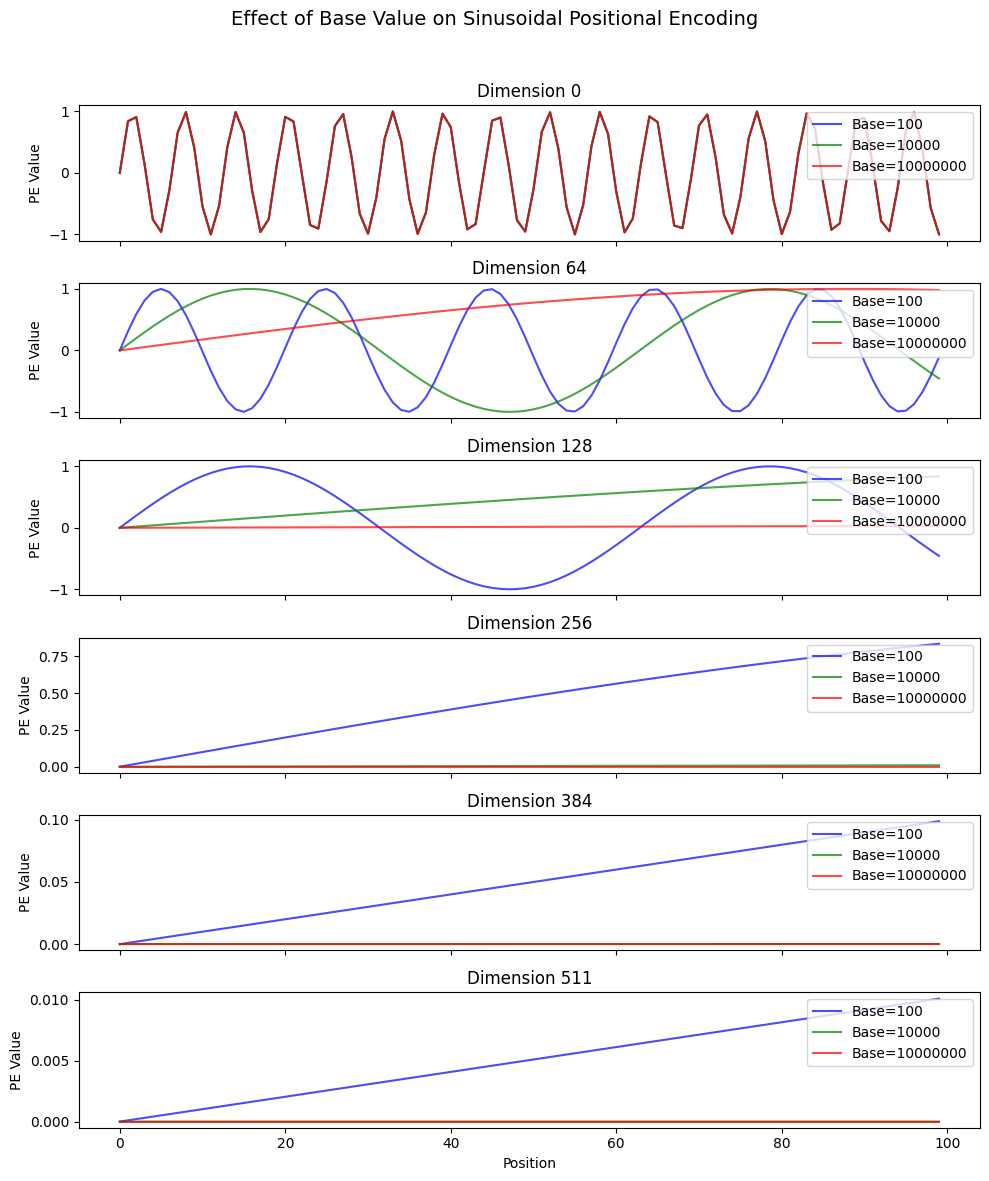

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Total embedding dimension
d_model = 512

# Position range
positions = np.arange(0, 100)

# Different base values to test
bases = [100, 10000, 1e7]
colors = ['blue', 'green', 'red']

# Choose several embedding dimensions to visualize
dims = [0, 64, 128, 256, 384, 511]

# Create subplots
fig, axs = plt.subplots(len(dims), 1, figsize=(10, 12), sharex=True)

for idx, i in enumerate(dims):
    for b, color in zip(bases, colors):
        angle = positions * np.exp(- (2 * i / d_model) * np.log(b))
        sin_values = np.sin(angle)
        axs[idx].plot(positions, sin_values, label=f'Base={int(b)}', color=color, alpha=0.7)
    
    axs[idx].set_title(f'Dimension {i}')
    axs[idx].legend(loc='upper right')
    axs[idx].set_ylabel('PE Value')

# Final layout
plt.xlabel('Position')
plt.suptitle('Effect of Base Value on Sinusoidal Positional Encoding', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
